In [29]:
# Standard library
import json
from copy import copy
from math import ceil, isfinite
from pathlib import Path
from time import monotonic
from typing import Any

# Math
import numpy as np
from numpy import array, deg2rad, eye, mean, ndarray, pi, set_printoptions, stack, rad2deg, deg2rad
from numpy.random import seed, standard_normal
from scipy.stats import norm, uniform

# Data Handling
import pandas as pd
from filterpy.monte_carlo import systematic_resample, stratified_resample

# Other Third Party
from rich.progress import track

# Plotting
import matplotlib
from keplergl import KeplerGl
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.transforms import Affine2D
from seaborn import move_legend
from svgpath2mpl import parse_path
from svgpathtools import svg2paths
import seaborn as sns

# ProMis
from promis import ProMis, StaRMap
from promis.geo import (
    CartesianCollection,
    CartesianMap,
    CartesianRasterBand,
    PolarCollection,
    PolarLocation,
)
from promis.loaders import NauticalChartLoader
from promis.logic.spatial import Depth


In [30]:
landscape = CartesianCollection.load(
    Path(".") / "cofi-exports" / "New York Harbor" / "landscape-cargo.pkl"
)
interpolator = landscape.get_interpolator("nearest")

constitutional_trust = 0

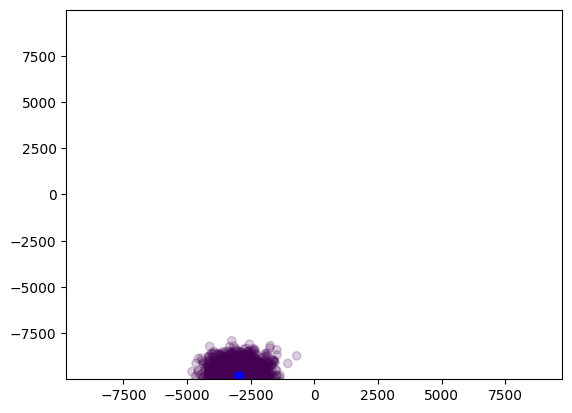

resampling


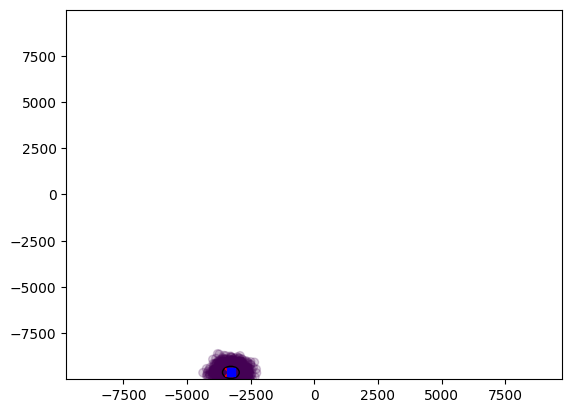

resampling


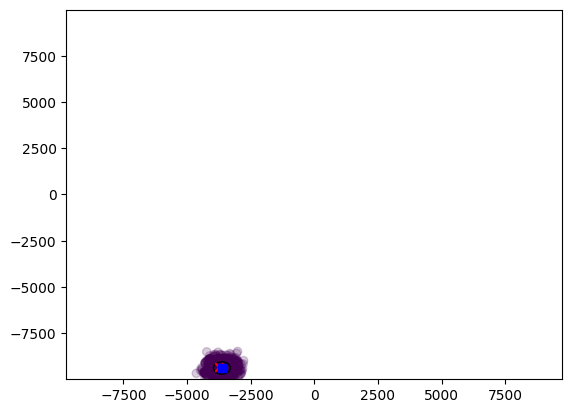

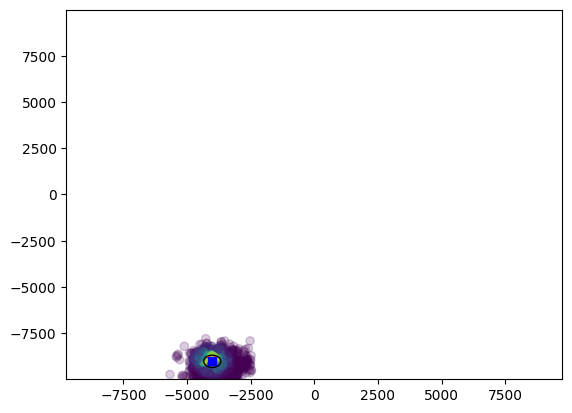

resampling


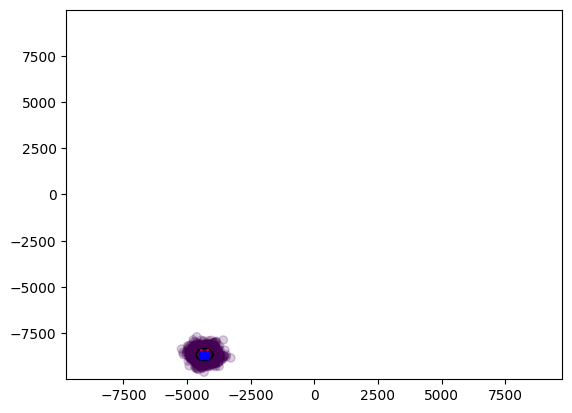

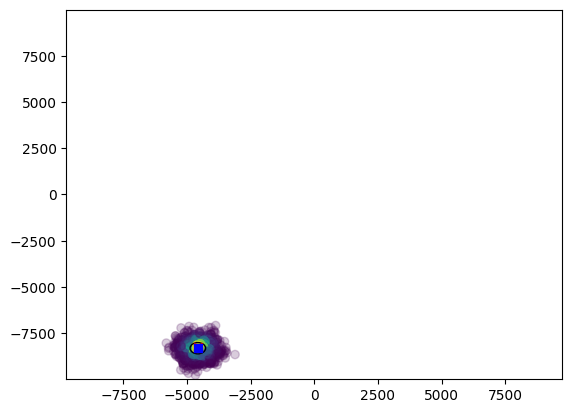

resampling


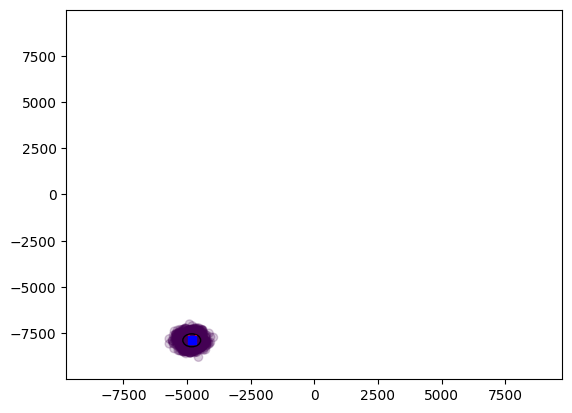

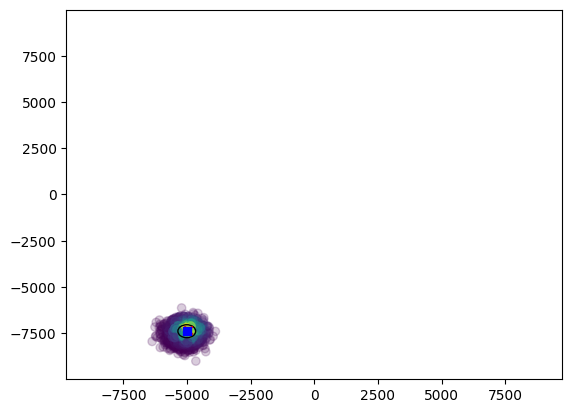

resampling


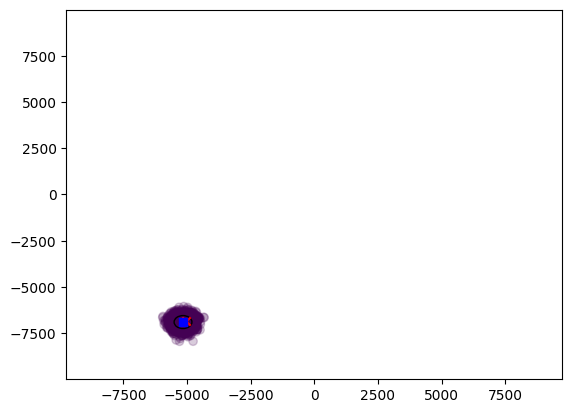

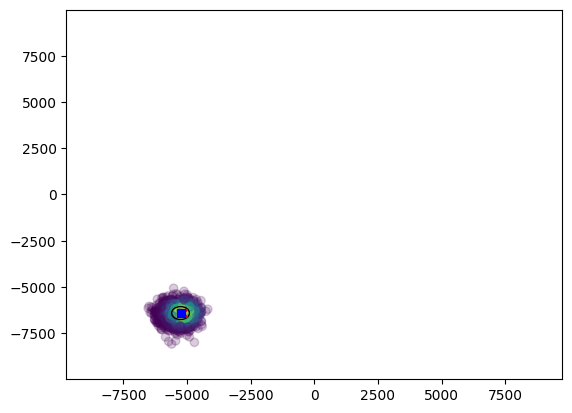

resampling


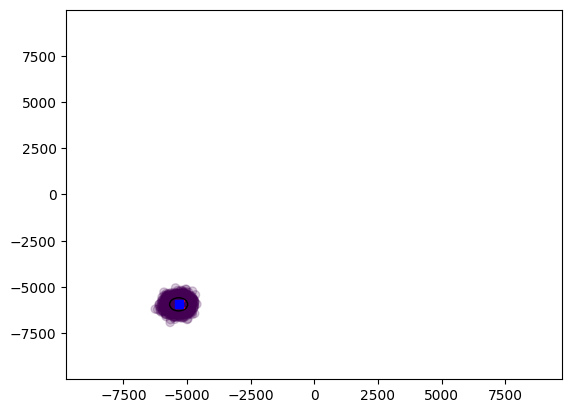

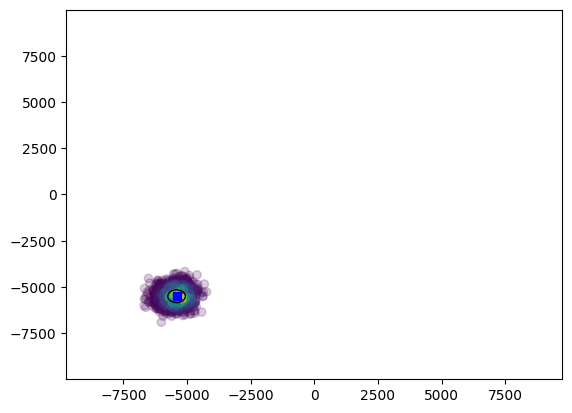

resampling


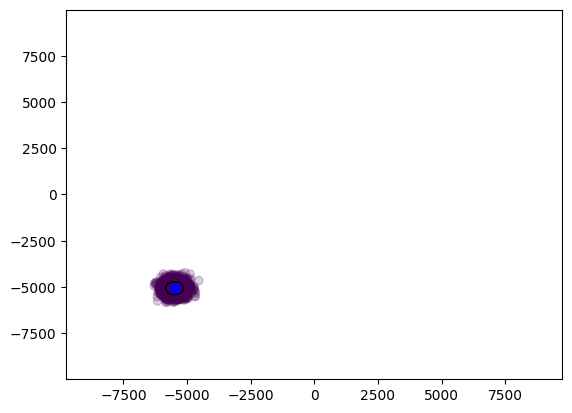

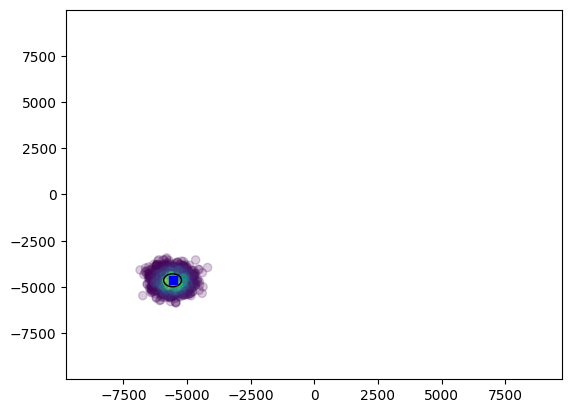

resampling


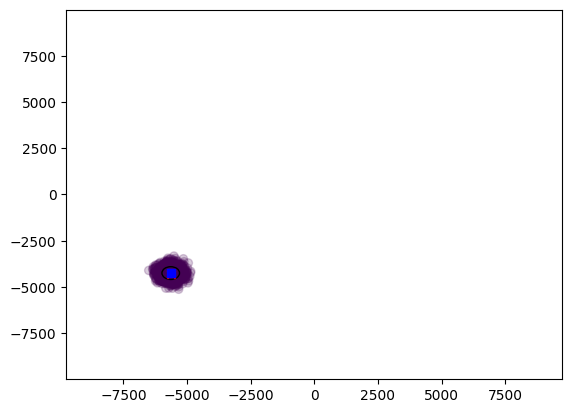

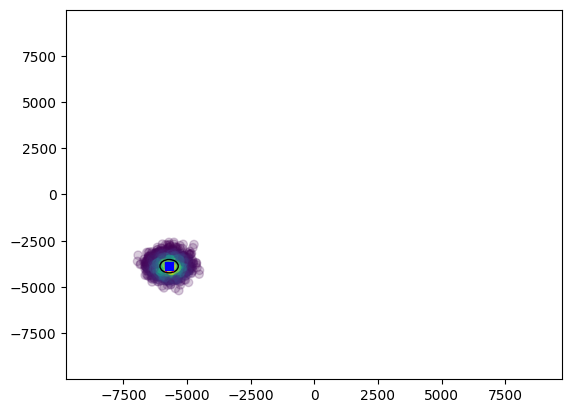

resampling


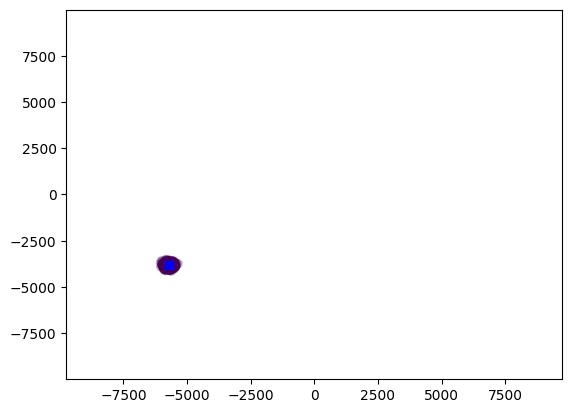

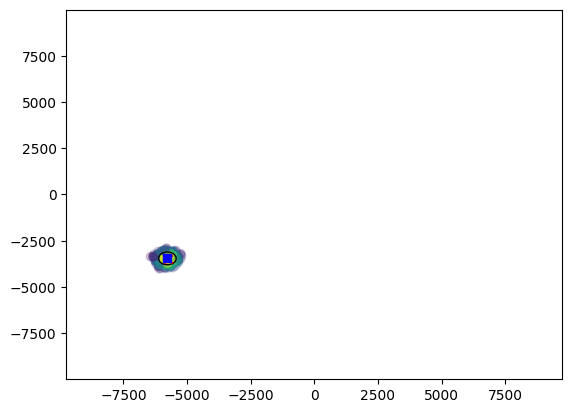

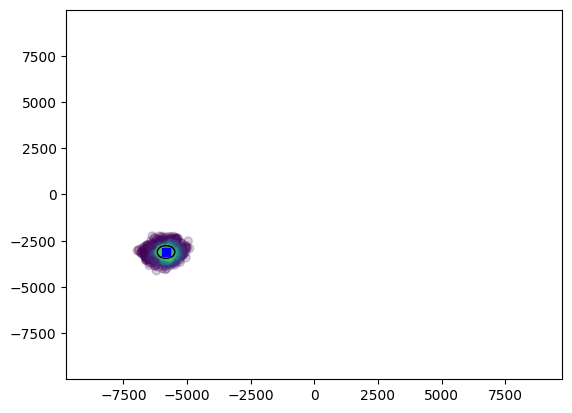

resampling


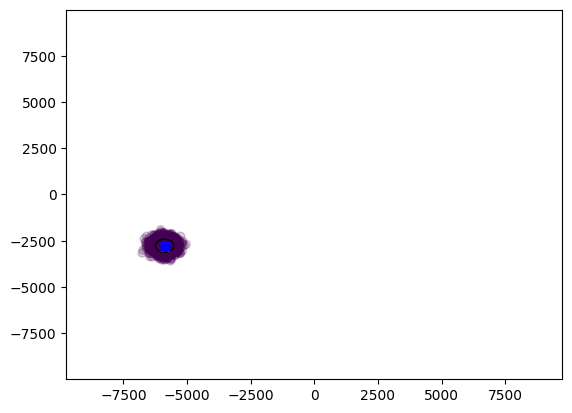

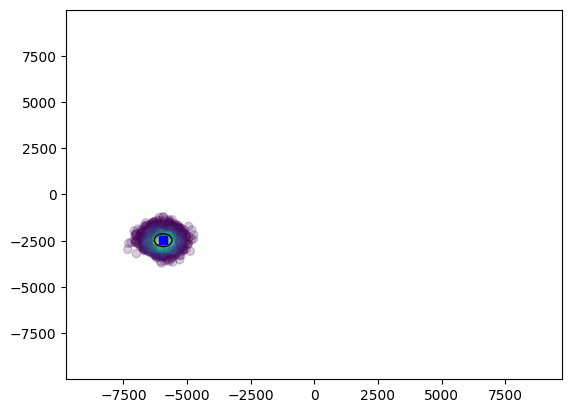

resampling


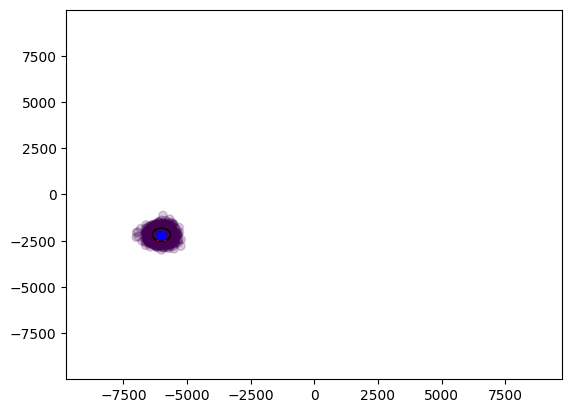

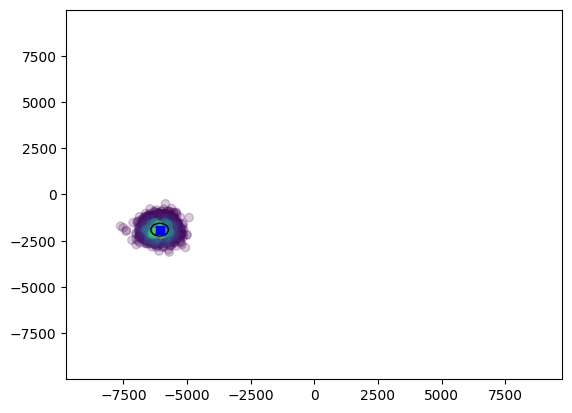

resampling


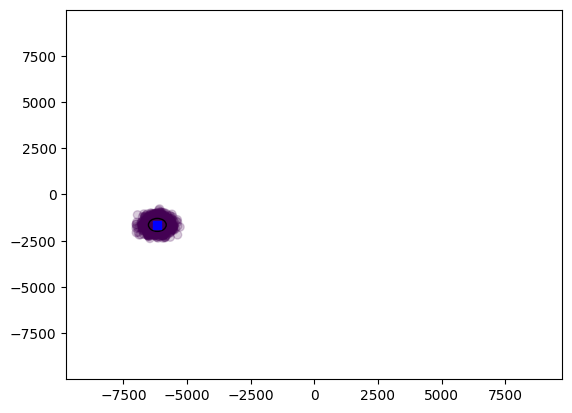

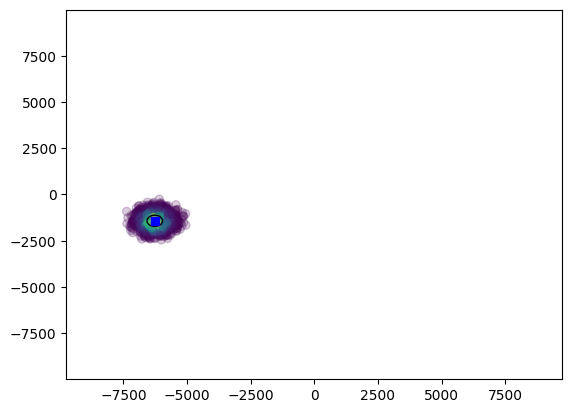

resampling


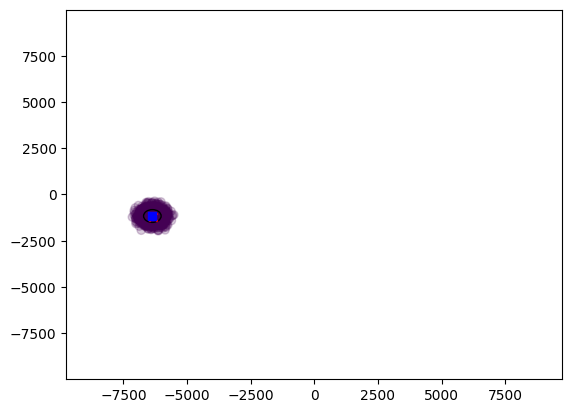

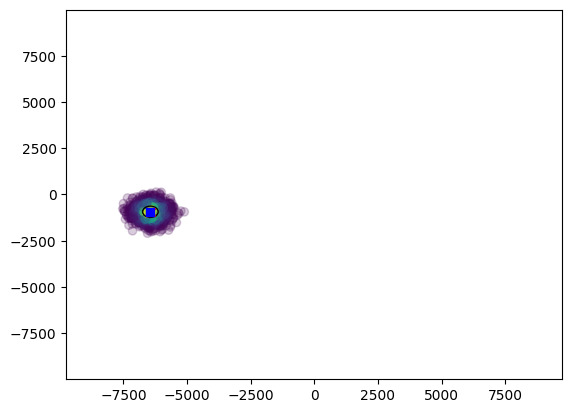

resampling


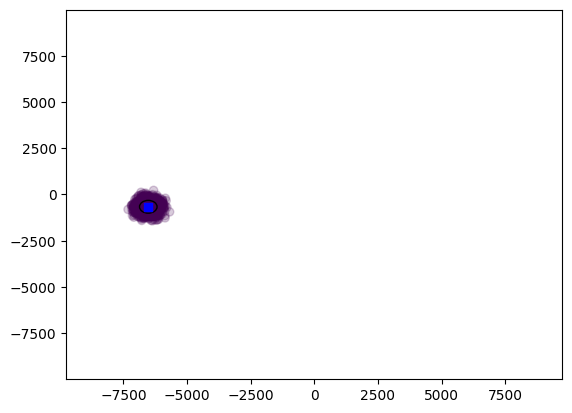

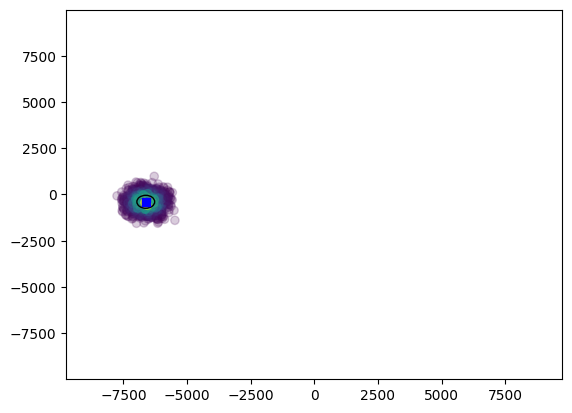

resampling


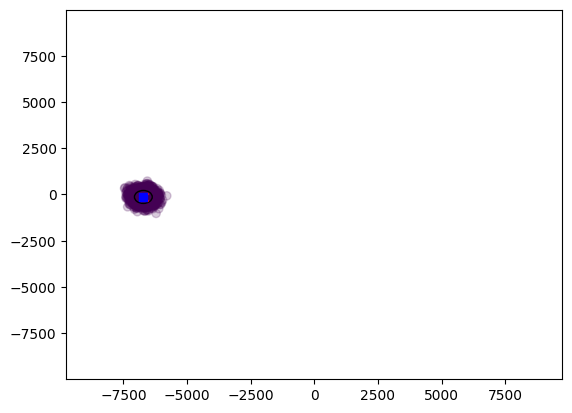

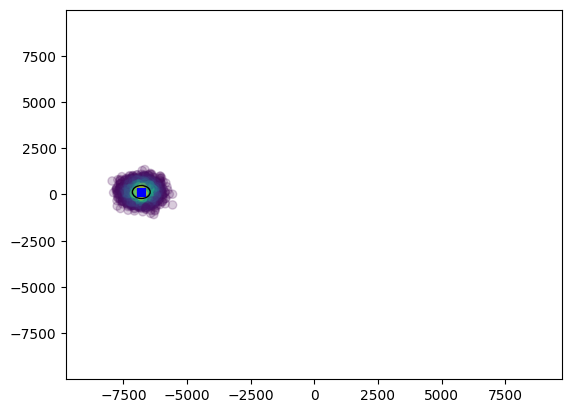

resampling


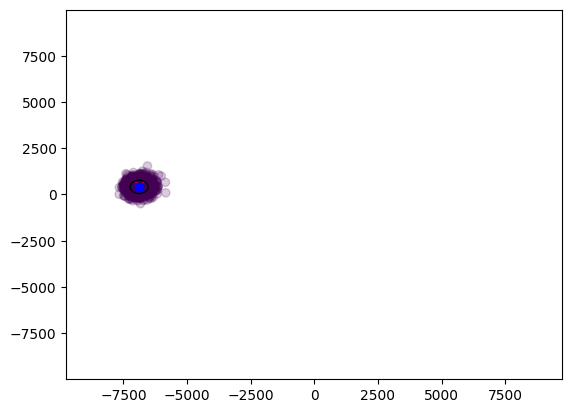

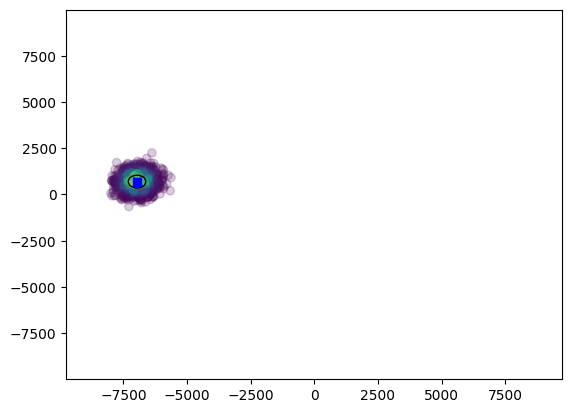

resampling


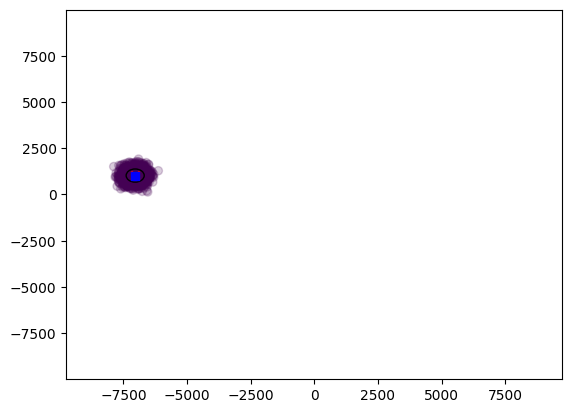

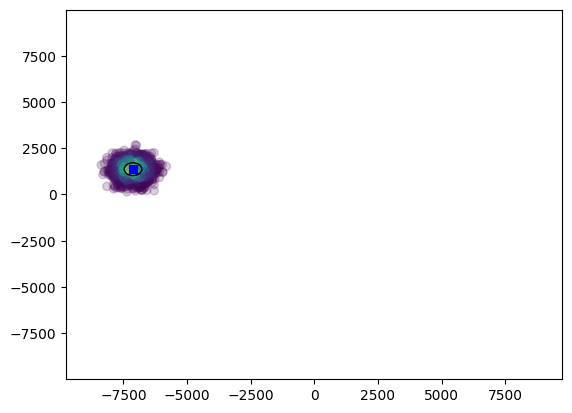

resampling


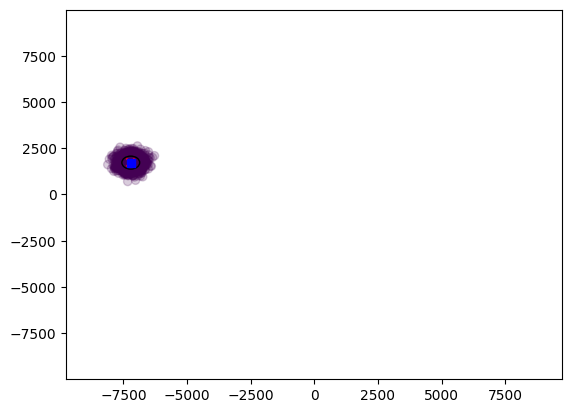

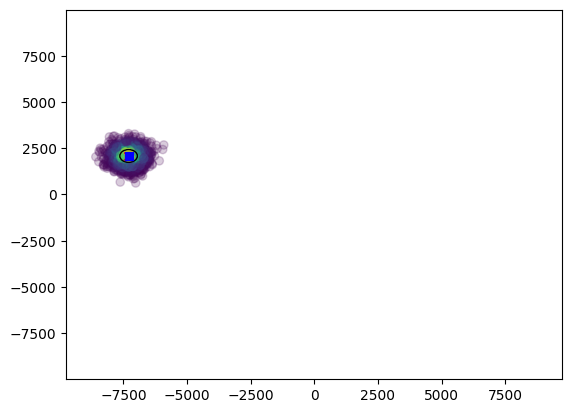

resampling


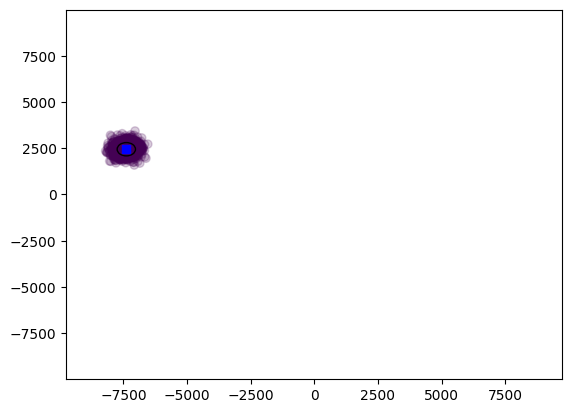

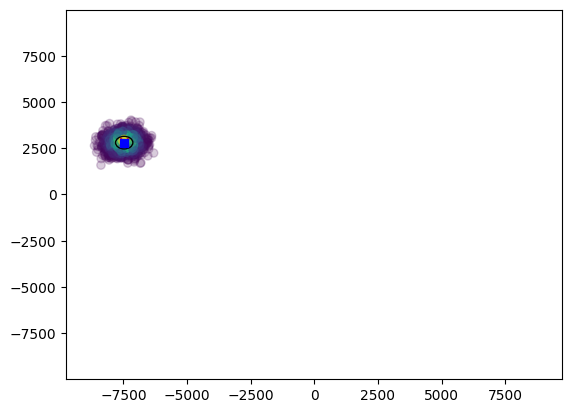

resampling


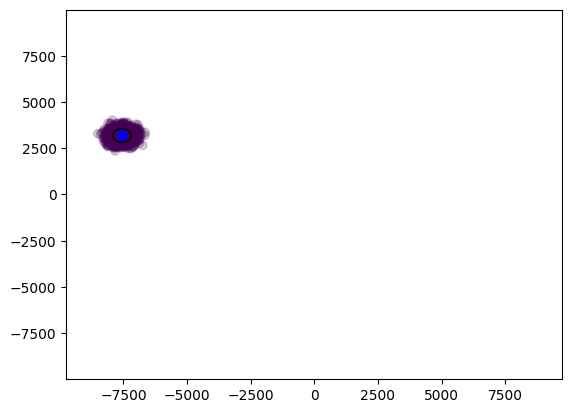

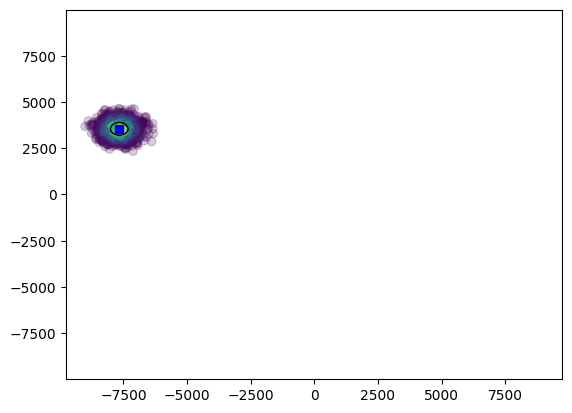

resampling


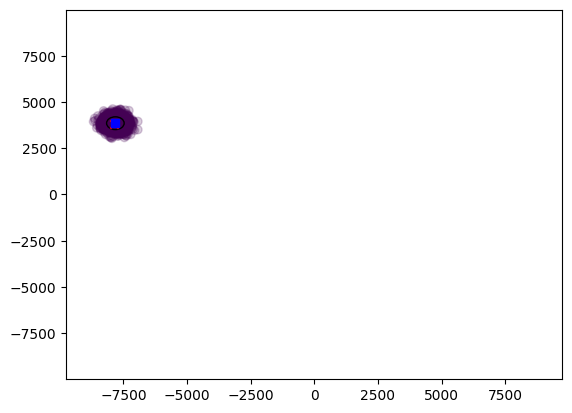

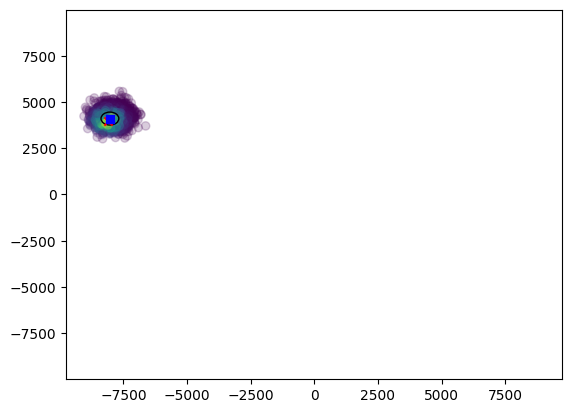

resampling


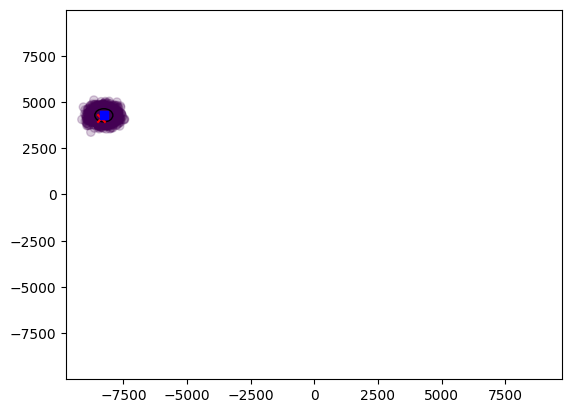

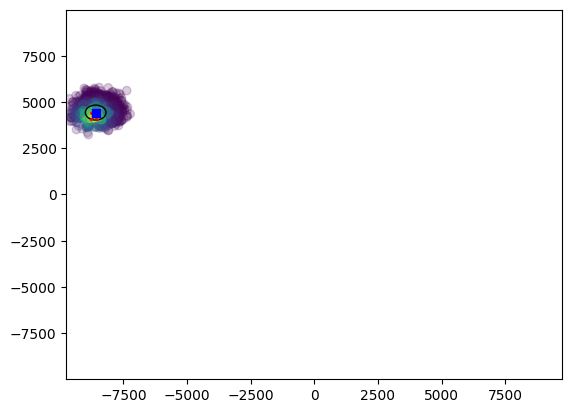

resampling


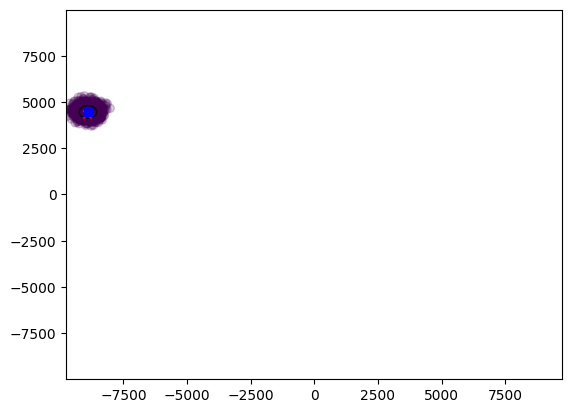

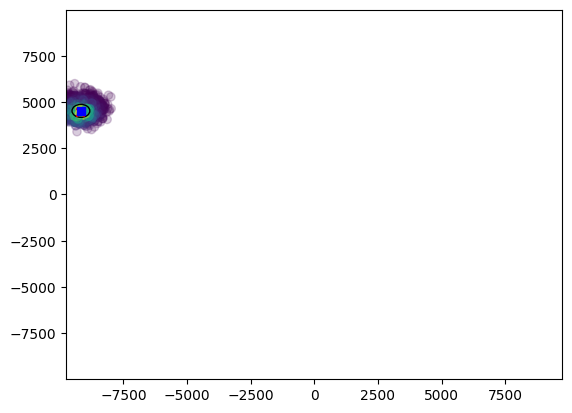

resampling


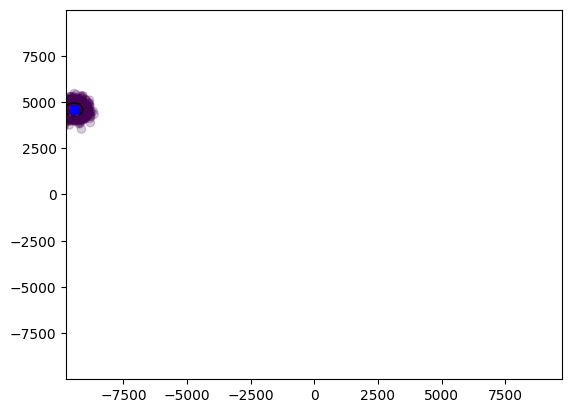

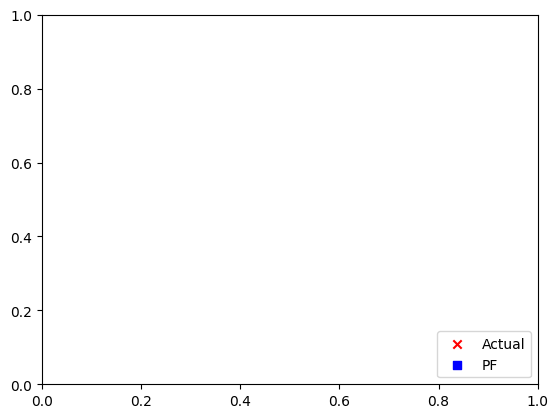

dict_keys(['particles', 'weights', 'estimates', 'pos_error', 'pos_error_mean', 'all_error', 'all_error_mean', 'truth'])

In [ ]:
seed_value = 2024
width, height = 19490.788929051603, 19988.34793513066

speed_log = []


N = 5_000
sensor_std_err = 0.2
process_noise = 0.0005


def create_initial_particles(N: int) -> ndarray:
    typical_ship_speed = 5
    return np.stack(
        [
            uniform(loc=-width / 2, scale=width).rvs(N),  # x position (east)
            uniform(loc=-height / 2, scale=height).rvs(N),  # y position (north)
            # uniform(loc=0, scale=2 * pi).rvs(N),  # heading
            # norm(loc=5, scale=3).rvs(N),  # speed
            norm(loc=0, scale=typical_ship_speed).rvs(N),
            norm(loc=0, scale=typical_ship_speed).rvs(N),
        ]
    ).T


def predict(particles, dt, process_noise):
    """move according to control input u (heading change, velocity)
    with noise Q (std heading change, std velocity)`"""

    particles = particles.copy()

    N = len(particles)

    # ##################################
    # # We first add noise to the heading
    # particles[:, 2] += deg2rad(
    #     standard_normal(N)  # we can turn 2 degrees per second in each direction (95% interval)
    # )
    # particles[:, 2] %= 2 * pi

    # # Add noise to the speed
    # particles[:, 3] += standard_normal(N) * 0.1
    # particles[:, 3] = np.clip(particles[:, 3], 0, 12)

    # # Compute the actual distance we travel
    # distance = particles[:, 3] * dt
    # particles[:, 0] += np.cos(particles[:, 2]) * distance
    # particles[:, 1] += np.sin(particles[:, 2]) * distance
    # # TODO: possibly also add noise to the heading
    # ##################################

    # noise = standard_normal(N) * std[1]
    # particles[:, [0, 1]] += particles[:, [2, 3]] * dt + noise

    # ##################################

    scaled_process_noise = process_noise * dt

    p = particles[:, [0, 1]]
    v = particles[:, [2, 3]]

    p_next = p + v * dt
    v_next = v + np.random.normal((0, 0), (scaled_process_noise, scaled_process_noise), size=(N, 2))

    particles[:, [0, 1]] = p_next
    particles[:, [2, 3]] = v_next

    return particles


def update(
    particles,
    weights,
    z,
    R,
    dt,
    constitutional_trust: float = constitutional_trust,
):
    weights = weights.copy()

    positions = particles[:, :2]
    distance = np.linalg.norm(positions - z, axis=1)

    # Evaluate an RBF kernel
    # weights *= np.exp(-(distance**2) / (2 * R**2))
    # print(distance.shape)
    # print(R)
    # print(z.shape)
    # weights *= norm(distance, R).pdf(distance)
    # weights *= norm(0, R).pdf(distance)
    if dt > 0.01:
        weights *= norm.pdf(distance, 0, R * dt)
    # weights *= norm(positions, R).pdf(z)

    if constitutional_trust > 0:
        # if landscape is None:
        #     # take a random subset of positions
        #     sampled_positions = positions[np.random.choice(len(positions), 100, replace=False)]
        #     this_landscape = landscape_for_mmsi(
        #         ship_df["MMSI"].iloc[0], where=sampled_positions, n_jobs=None
        #     )
        #     this_interpolator.get_interpolator()
        # else:
        #     this_interpolator = interpolator
        this_interpolator = interpolator
        constitution = this_interpolator(positions)[:, 0]
        weight_change = constitutional_trust * constitution + (1 - constitutional_trust) * 1
        # Disallow going to placed where the constitution is not even defined
        weight_change[~np.isfinite(constitution)] = 0
        weights *= weight_change

    weights += 1.0e-300  # avoid round-off to zero
    weights /= sum(weights)  # normalize

    return weights


def estimate(particles, weights):
    """returns mean and variance of the weighted particles"""

    mean = np.average(particles, weights=weights, axis=0)
    var = np.average((particles - mean) ** 2, weights=weights, axis=0)
    return mean, var


def neff(weights):
    return 1.0 / np.sum(np.square(weights))


def resample_from_index(particles, weights, indexes):
    particles[:] = particles[indexes]
    weights.resize(len(particles))
    weights.fill(1.0 / len(weights))


def run_pf1(
    N: int,
    data: np.ndarray,
    sensor_std_err,
    process_noise,
    do_plot=True,
    plot_particles=True,
    plot_every=1,
):
    if do_plot:
        plt.figure()

    # Create particles uniformly over the entire space
    particles = create_initial_particles(N)

    # However, for the location we can do a bit better by assuming that the current
    # observation is approximately correct
    assert data.shape[1] == 5
    particles[:, 0] = norm(loc=data[0, 0], scale=10 * 60).rvs(N)
    particles[:, 1] = norm(loc=data[0, 1], scale=10 * 60).rvs(N)

    # create weights
    weights = np.ones(N) / N

    alpha = 0.20
    # if do_plot and plot_particles:
    #     if N > 5000:
    #         alpha *= np.sqrt(5000) / np.sqrt(N)
    #     plt.scatter(particles[:, 0], particles[:, 1], alpha=alpha, color="g")
    #     plt.show()

    weights_trace = []
    particle_trace = []
    xs = []
    for i, obs in enumerate(data):
        dt = obs[4]

        # move
        particles = predict(particles, dt=dt, process_noise=process_noise)

        # incorporate measurements
        weights = update(particles, weights, z=obs[:2], R=sensor_std_err, dt=dt)

        # resample if too few effective particles
        if neff(weights) < N / 2:
        # if i % 5 == 0:
            print("resampling")
            indexes = systematic_resample(weights)
            resample_from_index(particles, weights, indexes)
            assert np.allclose(weights, 1 / N)

        mu, var = estimate(particles, weights)
        xs.append(mu)

        weights_trace.append(weights.copy())
        particle_trace.append(particles.copy())

        if do_plot and i % plot_every == 0:
            if plot_particles:
                plt.scatter(particles[:, 0], particles[:, 1], alpha=alpha, c=weights)
            # draw a cricle perimeter at 1 std
            plt.gca().add_artist(plt.Circle((mu[0], mu[1]), radius=sensor_std_err * dt, fill=False))
            p1 = plt.scatter(obs[0], obs[1], marker="x", color="r")
            p2 = plt.scatter(mu[0], mu[1], marker="s", color="b")
            plt.xlim(-width / 2, width / 2)
            plt.ylim(-height / 2, height / 2)
            plt.show()

    xs = np.array(xs)
    if do_plot:
        plt.legend([p1, p2], ["Actual", "PF"], loc=4, numpoints=1)
        plt.show()

    pos_error = np.linalg.norm(mu[:2] - data[:, :2], axis=1)
    all_error = np.linalg.norm(xs[:, :] - data[:, :4], axis=1)

    if do_plot:
        plt.show()

    return {
        "particles": array(particle_trace),
        "weights": array(weights_trace),
        "estimates": xs,
        "pos_error": pos_error,
        "pos_error_mean": pos_error.mean(),
        "all_error": all_error,
        "all_error_mean": all_error.mean(),
        "truth": data,
    }


# ship_df = ship_df.copy()
# ship_df.loc[:, "RelativeTime"] = (
#     ship_df["BaseDateTime"] - ship_df["BaseDateTime"].iloc[0]
# ).dt.total_seconds()
# assert ship_df["RelativeTime"].is_monotonic_increasing

# ground_truth = stack(
#     (
#         ship_df["East"],
#         ship_df["North"],
#         deg2rad(ship_df["COG"]),
#         ship_df["SOG"],
#         ship_df["RelativeTime"],
#     )
# ).T

# Make time start at zero
# ground_truth[0, 4] = 0
# ground_truth[1:, 4] = ground_truth[1:, 4] - ground_truth[:-1, 4]

# n_steps = 20
# ground_truth = stack(
#     (
#         np.full((n_steps,), 0),  # east
#         np.full((n_steps,), 0),  # north
#         np.full((n_steps,), 0),  # course over ground
#         np.full((n_steps,), 0),  # speed
#         np.arange(n_steps),  # relative time
#     )
# ).T

# n_steps = 20
# ground_truth = stack(
#     (
#         np.arange(n_steps) * 10,  # east
#         np.arange(n_steps) * 10,  # north
#         np.full((n_steps,), np.nan),  # course over ground
#         np.full((n_steps,), np.nan),  # speed
#         np.arange(n_steps),  # relative time
#     )
# ).T

ground_truth = np.array(
    [
        [-2948.118757, -9801.407044, 5.190609, 14.100000, 0.000000],
        [-3370.027333, -9582.470582, 5.192355, 14.000000, 66.000000],
        [-3751.210309, -9308.008359, 5.466371, 13.700000, 132.000000],
        [-4048.440577, -8959.172452, 5.633923, 13.500000, 199.000000],
        [-4326.991573, -8590.347249, 5.639159, 13.600000, 265.000000],
        [-4581.807728, -8245.955907, 5.668829, 13.700000, 326.000000],
        [-4811.123179, -7806.073364, 5.930629, 13.600000, 396.000000],
        [-4946.353875, -7326.270097, 6.038839, 13.700000, 466.000000],
        [-5057.008143, -6855.364301, 6.051057, 13.300000, 536.000000],
        [-5167.652230, -6390.008770, 6.059783, 13.000000, 606.000000],
        [-5269.821437, -5936.872222, 6.061528, 12.600000, 677.000000],
        [-5366.908668, -5500.394413, 6.059783, 12.100000, 746.000000],
        [-5457.223355, -5082.797727, 6.066764, 11.600000, 816.000000],
        [-5545.002268, -4685.189758, 6.080727, 11.000000, 886.000000],
        [-5626.864426, -4314.235927, 6.063274, 10.500000, 955.000000],
        [-5696.016455, -3942.180227, 6.124360, 10.100000, 1027.000000],
        [-5712.872995, -3840.005219, 6.124360, 10.000000, 1047.000000],
        [-5767.636361, -3485.726908, 6.129596, 9.700000, 1116.000000],
        [-5817.334520, -3156.992502, 6.131342, 9.400000, 1185.000000],
        [-5880.572319, -2826.026002, 6.049311, 8.800000, 1257.000000],
        [-5953.982878, -2519.480792, 6.049311, 8.500000, 1326.000000],
        [-6029.092130, -2227.369317, 6.016150, 8.300000, 1397.000000],
        [-6110.130151, -1946.356697, 5.993461, 8.000000, 1466.000000],
        [-6195.399978, -1672.002314, 5.969026, 7.800000, 1536.000000],
        [-6269.698878, -1444.295477, 5.976007, 7.600000, 1597.000000],
        [-6351.589322, -1191.040702, 5.967281, 7.700000, 1666.000000],
        [-6430.951274, -956.664971, 5.958554, 7.800000, 1727.000000],
        [-6522.970772, -684.521468, 5.955063, 7.900000, 1796.000000],
        [-6612.441548, -409.047569, 5.951573, 8.000000, 1866.000000],
        [-6704.450597, -140.232966, 5.969026, 8.100000, 1936.000000],
        [-6793.897942, 146.348004, 5.982989, 8.200000, 2006.000000],
        [-6882.490079, 435.150333, 5.977753, 8.600000, 2077.000000],
        [-6974.447673, 737.282606, 6.009169, 9.000000, 2146.000000],
        [-7059.597851, 1071.613254, 6.028367, 9.400000, 2217.000000],
        [-7142.207266, 1400.390294, 6.038839, 9.800000, 2286.000000],
        [-7228.168928, 1754.712453, 6.042330, 10.000000, 2356.000000],
        [-7310.741418, 2105.701085, 6.045821, 10.300000, 2425.000000],
        [-7396.668051, 2478.903563, 6.056293, 10.500000, 2497.000000],
        [-7480.060381, 2839.889553, 6.065019, 10.400000, 2565.000000],
        [-7562.586222, 3213.090997, 6.063274, 10.200000, 2637.000000],
        [-7677.287439, 3547.460224, 5.811946, 9.500000, 2706.000000],
        [-7869.030603, 3806.400413, 5.504768, 8.700000, 2775.000000],
        [-8109.897231, 3993.218365, 5.307546, 8.200000, 2845.000000],
        [-8364.323545, 4145.634781, 5.180137, 8.100000, 2916.000000],
        [-8676.286482, 4270.365019, 5.047492, 7.900000, 2997.000000],
        [-8940.914625, 4361.737151, 5.037020, 8.000000, 3066.000000],
        [-9213.992778, 4454.239664, 5.042256, 8.000000, 3136.000000],
        [-9487.074077, 4538.978922, 4.975934, 7.700000, 3206.000000],
    ]
)
n_steps = len(ground_truth)
# Make time start at zero
# ground_truth[0, 4] = 0
# ground_truth[1:, 4] = ground_truth[1:, 4] - ground_truth[:-1, 4]
ground_truth[:, 4] = np.diff(ground_truth[:, 4], prepend=0)

seed(seed_value)
result = run_pf1(
    N=2_000,
    data=ground_truth,
    sensor_std_err=5,
    process_noise=0.02,
)

result.keys()


In [32]:
# Rs = np.linspace(28, 32, 10)
# process_noises = np.linspace(0.65, 0.75, 10)

# results = []

# for Rs in track(Rs):
#     for process_noise in process_noises:
#         seed(seed_value)
#         result = run_pf1(
#             N=5_000,
#             data=ground_truth,
#             sensor_std_err=Rs,
#             do_plot=False,
#             process_noise=process_noise,
#         )
#         results.append(
#             {
#                 "R": Rs,
#                 "process_noise": process_noise,
#                 "pos_error_mean": result["pos_error_mean"].item(),
#             }
#         )

In [33]:
# # make a heatmap from it
# df = pd.DataFrame(results)
# df = df.pivot(
#     index="R",
#     columns="process_noise",
#     values="pos_error_mean",
# )
# sns.heatmap(df, vmax=6_500)
# plt.show()

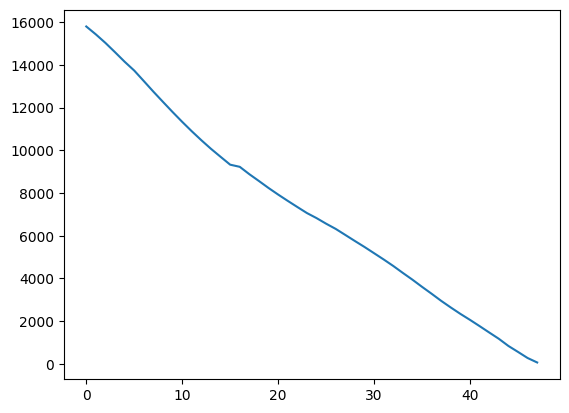

In [34]:
plt.plot(result["pos_error"])
pass

In [35]:
result["particles"].shape

(48, 2000, 4)

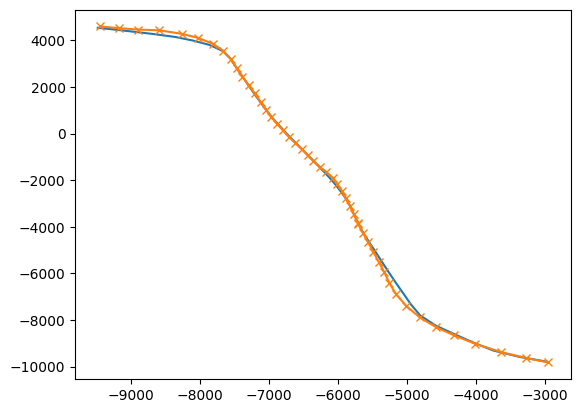

In [ ]:
# Show the actual path
plt.plot(result["truth"][:, 0], result["truth"][:, 1])
plt.plot(result["estimates"][:, 0], result["estimates"][:, 1], marker="x")
pass 

In [37]:
# for particle_trajectory in result["particles"].transpose(1, 0, 2):
#     plt.plot(particle_trajectory[:, 0], particle_trajectory[:, 1], alpha=0.1)

In [38]:
# fig, axes = plt.subplots(1, 2)

# for particle_trajectory in result["particles"].transpose(1, 0, 2):
#     axes[0].plot(particle_trajectory[:, 0], alpha=0.1)
#     axes[1].plot(particle_trajectory[:, 1], alpha=0.1)

# axes[0].plot(result["truth"][:, 0])
# axes[1].plot(result["truth"][:, 1])

# pass

In [39]:
# std err / R = 50
# process noise 1